<a href="https://colab.research.google.com/github/benny-png/transformer-Based-OCR-TrOCR-printed-and-handwritten-images/blob/main/Transformer_OCR_(TrOCR)_handwritten.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#HAND WRITTEN BASED OCR

from transformers import TrOCRProcessor, VisionEncoderDecoderModel
from PIL import Image
import numpy as np
import torch



In [2]:
# Initialize the processor and model
processor = TrOCRProcessor.from_pretrained('microsoft/trocr-base-handwritten')
model = VisionEncoderDecoderModel.from_pretrained('microsoft/trocr-base-handwritten')


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/224 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/1.12k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/772 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/4.17k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.33G [00:00<?, ?B/s]

Some weights of VisionEncoderDecoderModel were not initialized from the model checkpoint at microsoft/trocr-base-handwritten and are newly initialized: ['encoder.pooler.dense.bias', 'encoder.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


generation_config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Image shape: (34, 297, 3)


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1249: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Generated text: TRANSFORMER OCR (TROCR) JPYNB
The image used :


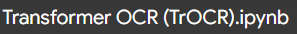

In [ ]:
# Load and preprocess the image
#THE IMAGE SHOULD ONLY CONTAIN IN LINE TEXT HERE

image_path = '/content/drive/MyDrive/TrOCR/Screenshot 2024-07-31 205620.png' #/content/drive/MyDrive/TrOCR/Screenshot 2024-07-31 210419.png
image = Image.open(image_path).convert("RGB")

# Convert image to a NumPy array
image_np = np.array(image)

# Check the shape of the image array to ensure it is (H, W, C)
print(f"Image shape: {image_np.shape}")



# Preprocess the image
pixel_values = processor(images=image_np, return_tensors="pt").pixel_values

# Generate text from the image
generated_ids = model.generate(pixel_values)
generated_text = processor.batch_decode(generated_ids, skip_special_tokens=True)[0]

print("Detected text: " + generated_text)

#display the image
print("The image used :")
image


In [5]:
#this is universal as it draws the bounding boxes using Pytesseract then perform OCR using TrOCR

# Ensure you have pytesseract installed
!apt-get install -y tesseract-ocr
!pip install pytesseract

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
tesseract-ocr is already the newest version (4.1.1-2.1build1).
0 upgraded, 0 newly installed, 0 to remove and 45 not upgraded.


In [6]:
# Import required packages
import cv2
import pytesseract
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from transformers import TrOCRProcessor, VisionEncoderDecoderModel

In [7]:
# Path to the image
image_path = "/content/drive/MyDrive/TrOCR/output-1.png"

def preprocess_image(image_path):
    # Read image from which text needs to be extracted
    img = cv2.imread(image_path)

    # Convert the image to gray scale
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Perform OTSU threshold
    ret, thresh1 = cv2.threshold(gray, 0, 255, cv2.THRESH_OTSU | cv2.THRESH_BINARY_INV)

    # Specify structure shape and kernel size
    rect_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (18, 18))

    # Apply dilation on the threshold image
    dilation = cv2.dilate(thresh1, rect_kernel, iterations=1)

    # Find contours
    contours, hierarchy = cv2.findContours(dilation, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)

    return img, contours

img, contours = preprocess_image(image_path)


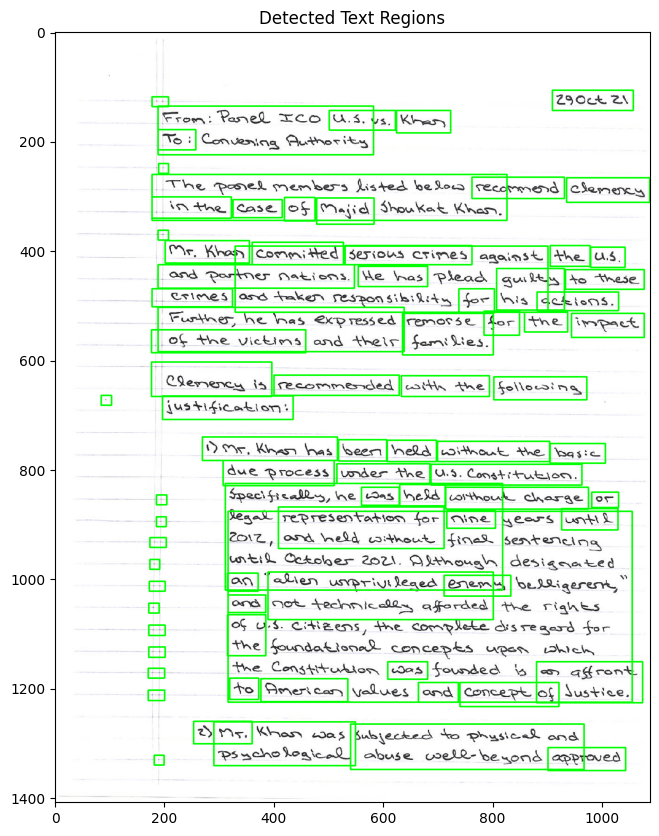

In [8]:
def display_bounding_boxes(img, contours):
    # Create a copy of the image
    im2 = img.copy()

    # Iterate through the contours and draw bounding boxes
    for cnt in contours:
        x, y, w, h = cv2.boundingRect(cnt)
        # Draw the bounding box on the image
        cv2.rectangle(im2, (x, y), (x + w, y + h), (0, 255, 0), 2)

    # Display the image with bounding boxes
    plt.figure(figsize=(10, 10))
    plt.imshow(cv2.cvtColor(im2, cv2.COLOR_BGR2RGB))
    plt.title('Detected Text Regions')
    plt.show()

display_bounding_boxes(img, contours)


In [10]:
def recognize_text(img, contours):
    # Initialize results list
    results = []
    im2 = img.copy()

    # Iterate through the contours, crop the detected text regions, and recognize text
    for cnt in contours:
        x, y, w, h = cv2.boundingRect(cnt)
        # Crop the detected text region
        cropped_image = img[y:y+h, x:x+w]
        cropped_image_pil = Image.fromarray(cv2.cvtColor(cropped_image, cv2.COLOR_BGR2RGB)).convert("RGB")

        # Preprocess the cropped image
        pixel_values = processor(images=cropped_image_pil, return_tensors="pt").pixel_values

        # Generate text
        generated_ids = model.generate(pixel_values)
        generated_text = processor.batch_decode(generated_ids, skip_special_tokens=True)[0]

        results.append(generated_text)
        print(generated_text)

        # Draw bounding box and recognized text on the image
        cv2.rectangle(im2, (x, y), (x + w, y + h), (0, 255, 0), 2)
        cv2.putText(im2, generated_text, (x, y - 10), cv2.FONT_HERSHEY_SIMPLEX, 1.5, (0, 255, 0), 3)

    return im2, results

# Recognize text and display the image with bounding boxes and recognized text
im2, results = recognize_text(img, contours)


0
approved
subject-under-technic work
psychological
29 m..
spots of
concept of
and
American
to
people up
of justice.
nias.
spy
spope
the
sp
and
pop
enemy
an
the most of the
0
spoken
0
0 0000
nine
until
2nd round
going
or
without charge
was
held
0 0 0
U.S. Constitution.
under the
due process.
basic
without the
held
been
19 Mr. Khan has
justification :
0 1
following
with the
recommended
I clemency is
toof the victims.
inspect
families.
the
for
for the suburbs of the United States
actions.
for
jcrimes.
to these
girls.
He has
and partner nations.
uis.
to describe the French
the
serious crimes.
committed
Mr. Khasn
sp
case
majid
of
firsthe
clemency.
recommend
# the predecessor of the Spanish Republic between
sp
toi
khan
U.S.VS.
Footnotes.
spy
29 Oct 21


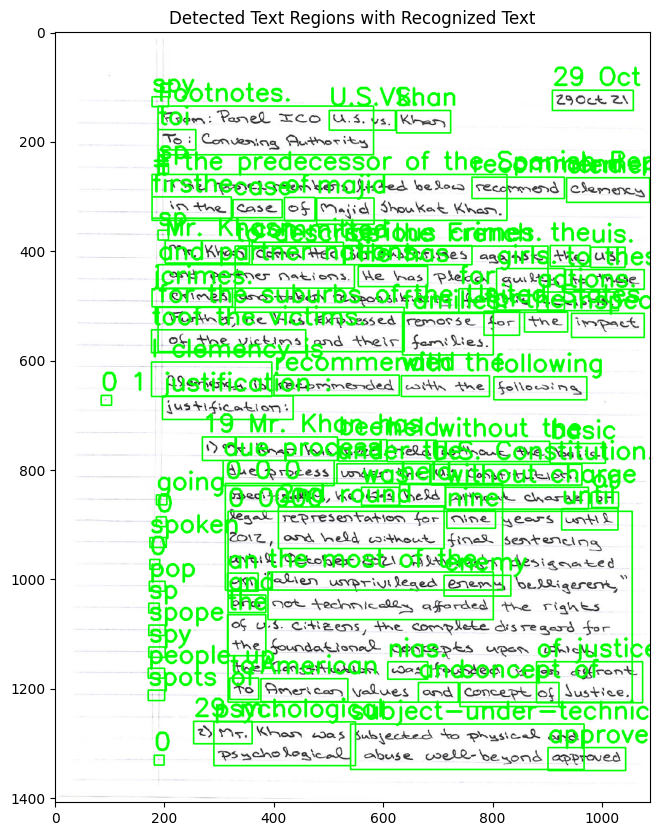

In [11]:
# Display the image with bounding boxes and recognized text
plt.figure(figsize=(10, 10))
plt.imshow(cv2.cvtColor(im2, cv2.COLOR_BGR2RGB))
plt.title('Detected Text Regions with Recognized Text')
plt.show()
